In [46]:
from sklearn.model_selection import train_test_split, KFold
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
from sklearn.preprocessing import LabelBinarizer
import tensorflow as tf
import matplotlib.pyplot as plt
import time
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score
from keras.models import Model
from keras.layers import Input, Convolution1D, Flatten, Dense, Dropout, Embedding, Concatenate,MaxPooling1D,concatenate 
from keras.optimizers import Adam, SGD
import tensorflow as tf
import nltk 
from gensim.models import Word2Vec
from nltk.tokenize import sent_tokenize, word_tokenize
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from numpy import zeros

In [47]:
#Hyper Parameters
FILE_NAME = "../../Data/processed_data.csv"
CNN_LAYER_SIZE =50
BATCH_SIZE = 32
EPOCH_LENGTH = 10
VALIDATION_PERCENTAGE = 0.1
TEST_SIZE_PERCENTAGE = 0.2
NUMBER_K_FOLDS = 3
LEARNING_RATE = 0.0005
VERBOSE = 1
MAX_LENGTH = 20
HIDDEN_ACTIVATION_FUNCTION = 'relu'
OUTPUT_ACTIVATION_FUNCTION = 'softmax'
LOSS_FUNCTION = 'categorical_crossentropy'
METRICS=['accuracy']
Y_LABEL_NAME="author"
X_LABEL_NAME="text"

In [48]:
#Read data
data = pd.read_csv(FILE_NAME)

In [49]:
documents = data[X_LABEL_NAME]
tokenizer = Tokenizer()

In [50]:
tokenizer.fit_on_texts(documents)
vocab_size = len(tokenizer.word_index) + 1

In [51]:
encoded_docs = tokenizer.texts_to_sequences(documents)


In [52]:
padded_docs = pad_sequences(encoded_docs, maxlen=MAX_LENGTH, padding='post')
print(padded_docs)

[[  294     4     1 ...    98     1   429]
 [   11    89   125 ...     0     0     0]
 [  560  3702    32 ...   345   476  2690]
 ...
 [10408  5067 15798 ...     0     0     0]
 [   17    34  4660 ...     0     0     0]
 [    6  6667  6561 ...     9     2  6006]]


In [53]:
max_length_for_padding=[] 
for i in encoded_docs:  
  max_length_for_padding.append(len(i))  
print(max(max_length_for_padding))

861


In [54]:
# load the whole embedding into memory
embeddings_index = dict()
f = open('../embeddings/glove.6B.100d.txt',encoding="utf8")
for line in f:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [55]:
# create a weight matrix for words in training docs
embedding_matrix = zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

In [56]:

#Defining model
def define_model(input_size, output_size, verbose = True, cnn_layer_size = 50,
                 hidden_activation_fn = 'relu', output_activation_fn='softmax',
                 learning = 0.0005, loss_function = 'categorical_crossentropy', metrics = ['accuracy']):
    
  
    # define model
    input =  Input(shape=(input_size,))
    emb_lay = Embedding(vocab_size, 100,weights=[embedding_matrix], input_length=MAX_LENGTH, trainable=True)(input)
    conv = Convolution1D(filters = cnn_layer_size, kernel_size = 1, activation=hidden_activation_fn)(emb_lay)
    flat1 = Flatten()(conv)
    output=Dense(units=output_size, activation=output_activation_fn)(flat1)

    # Create model
    model = Model(inputs = [input], outputs = [output])
    
    # Compile model
    model.compile(loss=loss_function, optimizer = Adam(learning_rate = learning), metrics=metrics)
    
    if verbose:
        print(model.summary())

    return model


 

In [57]:
#Get corpus and y label
text = data[X_LABEL_NAME]
author = data[Y_LABEL_NAME]

In [58]:
#Split data
text_train, text_test, author_train, author_test = train_test_split(text, author, test_size = TEST_SIZE_PERCENTAGE, random_state = 5)

In [59]:
X_train= tokenizer.texts_to_sequences(text_train)
X_train =  pad_sequences(X_train, maxlen=MAX_LENGTH, padding='post')

In [60]:

X_test= tokenizer.texts_to_sequences(text_test)
X_test =  pad_sequences(X_test, maxlen=MAX_LENGTH, padding='post')

In [61]:

#Get input and output dimensions
input_size = X_train.shape[1]
output_size = len(author.unique())

In [62]:
# One hot encode y labels
author_lb = LabelBinarizer()
author_lb.fit(author_train)
author_train_hot = author_lb.transform(author_train)
author_test_hot = author_lb.transform(author_test)

In [63]:
print(np.shape(X_train))
print(np.shape(X_test))
print(np.shape(author_train))
print(np.shape(author_test))

(15663, 20)
(3916, 20)
(15663,)
(3916,)


In [64]:
print(np.shape(X_train))
print(np.shape(X_test))

(15663, 20)
(3916, 20)


In [65]:
# Sets seed
np.random.seed(28)
kf = KFold(n_splits = NUMBER_K_FOLDS)

test_accuracy_list = []
prec_list = []
recall_list = []
f1_list = []
training_time_list = []
prediction_time_list = []
full_history =[]

run = 0


for train_inds, _ in kf.split(X_train):
    run += 1
    print('Run:', run)
       
    train_x = np.array([X_train[i] for i in train_inds])
    train_y = np.array([author_train_hot[i] for i in train_inds])
       
    t0 = time.time()
    # Fit model
    cnn_model = define_model(input_size= input_size, output_size= output_size, verbose = False,
                      cnn_layer_size = CNN_LAYER_SIZE, hidden_activation_fn = HIDDEN_ACTIVATION_FUNCTION,
                      output_activation_fn = OUTPUT_ACTIVATION_FUNCTION, learning=LEARNING_RATE, loss_function = LOSS_FUNCTION, metrics=METRICS)

    histroy = cnn_model.fit(train_x, train_y, epochs=EPOCH_LENGTH, batch_size=BATCH_SIZE, verbose = VERBOSE,validation_split = VALIDATION_PERCENTAGE)
  
    t1 = time.time()
    
    # Predict values for test set
    author_pred1 = cnn_model.predict(X_test)
    author_pred1 = author_lb.inverse_transform(author_pred1)

    t2 = time.time()

    # Evaluate
    test_accuracy = accuracy_score(author_test, author_pred1)
    precision, recall, f1, support = score(author_test, author_pred1)
    ave_precision = np.average(precision, weights = support/np.sum(support))
    ave_recall = np.average(recall, weights = support/np.sum(support))
    ave_f1 = np.average(f1, weights = support/np.sum(support))
    training_time = (t1 - t0)
    prediction_time = (t2 - t1)
    
    test_accuracy_list.append(test_accuracy)
    prec_list.append(ave_precision)
    recall_list.append(ave_recall)
    f1_list.append(ave_f1)
    training_time_list.append(training_time)
    prediction_time_list.append(prediction_time)
    full_history.append(histroy)

print("Test Accuracy:", test_accuracy_list)
print("Ave. Precision:", prec_list)
print("Ave. Recall:", recall_list)
print("Ave. F1 Score:", f1_list)

Run: 1
Epoch 1/10
294/294 [==============================] - 6s 21ms/step - loss: 1.0392 - accuracy: 0.4741 - val_loss: 0.9666 - val_accuracy: 0.5407
Epoch 2/10
294/294 [==============================] - 6s 20ms/step - loss: 0.8512 - accuracy: 0.6242 - val_loss: 0.8561 - val_accuracy: 0.6201
Epoch 3/10
294/294 [==============================] - 6s 20ms/step - loss: 0.7060 - accuracy: 0.7111 - val_loss: 0.7958 - val_accuracy: 0.6584
Epoch 4/10
294/294 [==============================] - 6s 20ms/step - loss: 0.5680 - accuracy: 0.7820 - val_loss: 0.7481 - val_accuracy: 0.6775
Epoch 5/10
294/294 [==============================] - 6s 20ms/step - loss: 0.4450 - accuracy: 0.8464 - val_loss: 0.7195 - val_accuracy: 0.7062
Epoch 6/10
294/294 [==============================] - 6s 19ms/step - loss: 0.3412 - accuracy: 0.8906 - val_loss: 0.7054 - val_accuracy: 0.7100
Epoch 7/10
294/294 [==============================] - 6s 20ms/step - loss: 0.2530 - accuracy: 0.9299 - val_loss: 0.7130 - val_accuracy:

In [66]:
#Get averages for kfold runs
mean_accuracy_across_kfold = np.mean(test_accuracy_list)
mean_percision_across_kfold = np.mean(prec_list)
mean_recall_across_kfold = np.mean(recall_list)
mean_f1_across_kfold = np.mean(f1_list)


print("Average Accuracy across K-folds:", mean_accuracy_across_kfold)
print("Average Precision across K-folds:", mean_percision_across_kfold)
print("Average Recall across K-folds:", mean_recall_across_kfold)
print("Average F1 Score across K-folds:", mean_f1_across_kfold)
print("Average Training Time across K-folds:", (t1 - t0), "seconds")
print("Prediction Time across K-folds:", (t2 - t1), "seconds")

Average Accuracy across K-folds: 0.7410623084780389
Average Precision across K-folds: 0.7420359773113633
Average Recall across K-folds: 0.7410623084780389
Average F1 Score across K-folds: 0.7408262576826106
Average Training Time across K-folds: 58.57004475593567 seconds
Prediction Time across K-folds: 0.16100096702575684 seconds


In [67]:
average_test_loss_accross_kfold = []
average_validation_loss_accross_kfold = []
average_test_accuracy_accross_kfold = []
average_validation_accuracy_accross_kfold = []

for i in range(len(full_history)):
    average_test_loss_accross_kfold.append(full_history[i].history['loss'])
    average_validation_loss_accross_kfold.append(full_history[i].history['val_loss'])

    average_test_accuracy_accross_kfold.append(full_history[i].history['accuracy'])
    average_validation_accuracy_accross_kfold.append(full_history[i].history['val_accuracy'])

average_loss_accross_kfold = np.mean(average_test_loss_accross_kfold,axis=0)
average_validation_loss_accross_kfold = np.mean(average_validation_loss_accross_kfold,axis=0)

average_accuracy_accross_kfold = np.mean(average_test_accuracy_accross_kfold,axis=0)
average_validation_accuracy_accross_kfold = np.mean(average_validation_accuracy_accross_kfold,axis=0)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


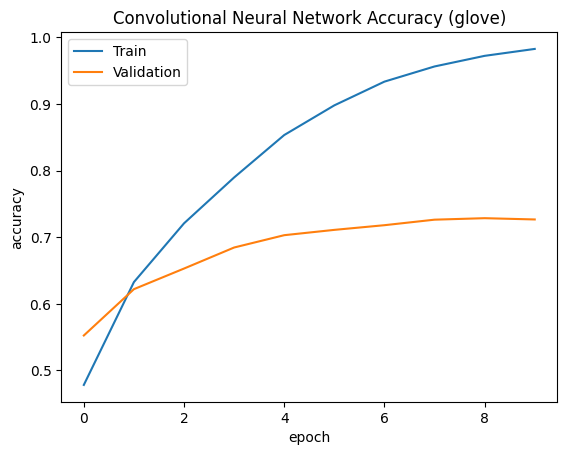

In [68]:
# summarize history for accuracy
plt.plot(average_accuracy_accross_kfold)
plt.plot(average_validation_accuracy_accross_kfold)
plt.title('Convolutional Neural Network Accuracy (glove)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig("../outputs/Convolutional_neural_network_glove_acc.eps", format='eps')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


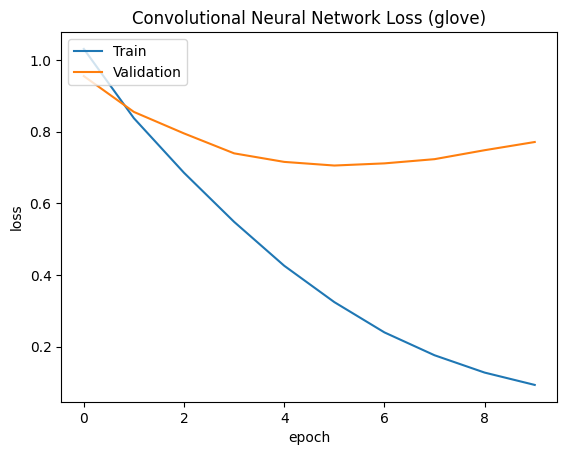

In [69]:
# summarize history for loss
plt.plot(average_loss_accross_kfold)
plt.plot(average_validation_loss_accross_kfold)
plt.title('Convolutional Neural Network Loss (glove)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig("../outputs/Convolutional_neural_network__glove_loss.eps", format='eps')
plt.show()